# Notebook with Functions to visulaize expected ROH within different Length classes given some Ne

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import socket
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.colors as cls
import h5py   # For Processing HDF5s

### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./package/")
from hapsburg.PackagesSupport.roh_expectations import Expected_Roh

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


## Test/calculate expectations for low Ne as well as Cousins

In [2]:
###
vrange = [0.04, 0.8]
N_arr = [200, 1000, 5000, 25000]  # The values of 2N
c_arr = [1, 2, 3] # The value of cousins

e_roh = Expected_Roh()  # Get the object to do calculation

x_arr = np.arange(vrange[0], vrange[1], 0.0001)
bw = x_arr[1] - x_arr[0]  # Bin Width
x_mean = (x_arr[1:] + x_arr[:-1]) / 2

y_roh_cs = np.zeros((len(c_arr), len(x_mean)), dtype="float") # Container for N results
for i,c in enumerate(c_arr):
    y_roh_cs[i,:] = e_roh.exp_roh_ind_rel(x_mean, m=(c*2+4), comm_anc=4) * x_mean
    
y_roh_Ns = np.zeros((len(N_arr), len(x_mean)), dtype="float") # Container for N results
for i,N in enumerate(N_arr):
    y_roh_Ns[i,:] = e_roh.roh_pdf_allchr_N(x_mean, N=N) * x_mean

In [3]:
np.sum(y_roh_cs*bw, axis=1)

array([2.083522  , 0.52283509, 0.12856589])

In [4]:
np.sum(y_roh_Ns*bw, axis=1)

array([3.82518263, 0.82415447, 0.16738527, 0.03358086])

### Plot Expected ROH Density per Individual

Saved figure to ./figures_test/roh_expectations.pdf


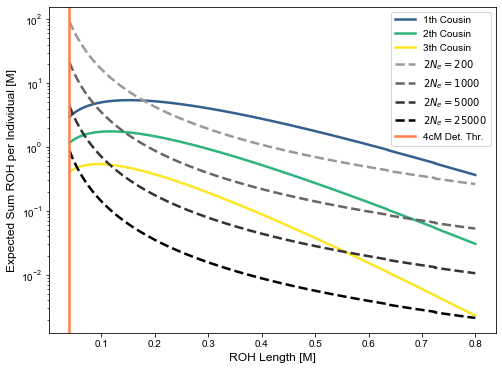

In [6]:
lw=2.5
fs=12
fs_l=10
figsize=(8,6)
savepath = "./figures_test/roh_expectations.pdf"

plt.figure(figsize=figsize)
ax = plt.gca()

cmap = cm.get_cmap('viridis')
cs = np.linspace(0.3,1,len(c_arr))

### Plot the Cousins
for i,c in enumerate(c_arr):
    ax.plot(x_mean, y_roh_cs[i,:], "-", c=cmap(cs[i]), lw=lw, label=f"{c}th Cousin")
    
cmap = cm.get_cmap('gray_r')
cs = np.linspace(0.4, 1.0, len(N_arr))

### Plot the Pop Sizes
for i,N in enumerate(N_arr):
    ax.plot(x_mean, y_roh_Ns[i,:], "--", c=cmap(cs[i]), lw=lw, label=f"$2N_e={N}$")

ax.set_xlabel("ROH Length [M]", fontsize=fs)
ax.set_ylabel("Expected Sum ROH per Individual [M]", fontsize=fs)

ax.set_yscale("log")
ax.axvline(x=0.04, c="coral", label="4cM Det. Thr.", lw=lw)
ax.legend(loc="upper right", fontsize=fs_l)
if len(savepath)>0:
    plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
    print(f"Saved figure to {savepath}")

plt.show()

## Functions

In [39]:
def roh_len_indef(l, Ne, G=35.44562, fac=1):
    """Indefinite function of ROH sharing Length
    [use Morgan units]"""
    Ne = fac * Ne # To take into account the factor of two
    pre = -8 / (Ne) * G
    num = (1/Ne) + 4*l
    den = 8* (1/Ne + 2*l)**2
    res = pre * num/den
    return res

def roh_len(l0, l1, Ne, fac=1, G=35.44562):
    """Expected ROH length between l0 and l1
    [return in Morgan]"""
    tot_l = roh_len_indef(l1, Ne, G=G, fac=fac) - roh_len_indef(l0, Ne, G=G, fac=fac)
    return tot_l

In [93]:
roh_len(0.04, 0.08, Ne=250, fac=1)

1.587429175755172

In [90]:
roh_len(0.04, 0.08, Ne=500, fac=1)

0.838170580379563

In [102]:
roh_len(0.04, 0.08, Ne=1000, fac=1)

0.43084720878859994

In [10]:
roh_len(0.04, 0.08, Ne=2000, fac=1)

0.21844982373360688

In [99]:
roh_len(0.04, 20000, Ne=250, fac=1)

3.2953906886548405

In [100]:
roh_len(0.04, 20000, Ne=500, fac=1)

1.7079650574608711

In [101]:
roh_len(0.04, 20000, Ne=1000, fac=1)

0.8697962493621086

In [8]:
roh_len(0.04, 20000, Ne=20000, fac=1)

0.04426543313785336

### Make Figure

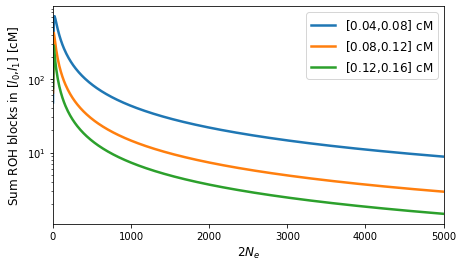

In [104]:
fs = 12
lw = 2.5
xlim=[0,5000]
x = np.linspace(xlim[0]+1, xlim[1], 500)
l_vec = np.array([[0.04,0.08],[0.08,0.12],[0.12, 0.16]]) # ]


plt.figure(figsize=(7,4))
ax = plt.gca()

for i,l in enumerate(l_vec):
    y =  np.array([roh_len(l[0], l[1], Ne=i, fac=1) for i in x]) * 100
    ax.plot(x, y, label=f"[${l[0]}$,${l[1]}$] cM", lw=lw)

ax.legend(fontsize=fs)
ax.set_xlabel(f"$2N_e$", fontsize=fs)
ax.set_ylabel(f"Sum ROH blocks in [$l_0$,$l_1$] [cM]", fontsize=fs)
ax.set_xlim(xlim)
ax.set_yscale("log")
plt.show()

In [17]:
bins = np.arange(0.04, 2.5,0.01)
y = np.zeros(len(bins)-1)

for i in range(1,len(bins)):
    y[i-1] =  roh_len(bins[i-1], bins[i], Ne=500, fac=1) * 100

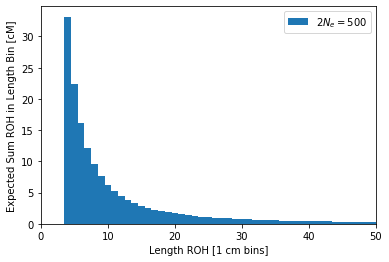

In [32]:
plt.figure()
plt.bar(bins[:-1]*100, y, width=1, label=f"$2N_e=500$")
plt.xlim([0,50])
plt.ylabel("Expected Sum ROH in Length Bin [cM]")
plt.xlabel("Length ROH [1 cm bins]")
#plt.yscale("log")
plt.legend(loc="upper right")
plt.show()

In [28]:
np.sum(y[:4])

83.81705803795634

In [ ]:
import pandas as pd
import numpy as np

# Functions to describe sharing of ROH:
### Migrate to Python Function eventually!

In [ ]:
### Don't need to run, produces one time Chr. Lengths
def load_h5(path, output=True):
        """Load and return the HDF5 File from Path"""
        f = h5py.File(path, "r")  # Load for Sanity Check. See below!
        if output == True:
            print("\nLoaded %i variants" % np.shape(f["calldata/GT"])[0])
            print("Loaded %i individuals" % np.shape(f["calldata/GT"])[1])
            # print(list(f["calldata"].keys()))
            # print(list(f["variants"].keys()))
            print(f"HDF5 loaded from {path}")
        return f

def chrom_length(ch, output=False):
    """Get and retrun length of Chromosome"""
    
    path1000G = "./Data/1000Genomes/HDF5/1240kHDF5/Eur1240chr" + str(ch) + ".hdf5"  # Path of 1000G (without chromosome part)
    f = load_h5(path1000G, output=output)
    rec = np.array(f["variants/MAP"])
    l = np.max(rec) - np.min(rec)  # Do the accessible Chromosomes
    return rec, l

ch_l = []
for i in range(1,23):
    a = chrom_length(i)[1]
    ch_l += [chrom_length(i)[1],]
print(ch_l)

### Functions for Cousins

In [10]:
e_roh = Expected_Roh()
#e_roh.exp_roh_len_in_bin_rel(l=[0.0,3], m=8, comm_anc=4, bins=1000) #/ np.sum(ch_l)

### Functions for Pop Size N_e

In [5]:
e_roh.exp_roh_len_in_bin_N(l=[0, 3.5], N=500, bins=10000)

35.68769749190413

In [6]:
e_roh.exp_roh_len_in_bin_rel(l=[0.4, 3.0], m=6, comm_anc=4)

0.5605230805435659

In [41]:
e_roh.exp_roh_len_in_bin_N(l=[0.4, 3.0], N=500, bins=10000)

0.13240664522164036

### Make some Figures

In [31]:
np.sum(e_roh_nr_c1)*bw

2.209837478611569

In [32]:
np.sum(e_roh_nr_c2)*bw

0.5528396767823635

### Plot Ne across t
Do it for ROH of length 4

In [3]:
def plot_time_exp(t_vec = np.arange(0, 250), N=500, bl_lengths = [0.04, 0.08, 0.12, 0.20],
                  ylw=2.5, cmap='viridis', fs=12, fs_l=10, lw=2, colors=[],
                  figsize=(5,5), savepath = "./figures/manuscript/supplement/exp_dens_t_N.pdf"):
    """
    Plot curves about the expected time density 
    when plot sharing comes from. Do calculations as well as plot (maybe
    split later)
    colors: What colors to use."""   
    ### Do the Calculations
    y = np.array([e_roh.roh_pdf_allchr_t_N(bl, t=t_vec, N=N) for bl in bl_lengths])
    y_cumsum = np.cumsum(y, axis=1) ## For Cumulative Sum
    
    ### Do the Plot:
    if len(colors)==0:
        cs = np.linspace(0.3, 1, len(bl_lengths))
        cmap = cm.get_cmap(cmap)
        colors = [cmap(c) for c in cs]
    assert(len(colors)==len(bl_lengths))

    ### Full Integral:
    int_res = [e_roh.roh_pdf_allchr_N(x=bl, N=N) for bl in bl_lengths]

    plt.figure(figsize=figsize)
    ax = plt.gca()
    ax2 = ax.twinx()
    #ax2.set_ylim(ax1.get_ylim())
    #ax2.set_yticks(np.array([1,0]) * 1.1 - 0.05)
    #ax2.set_yticklabels([])
    #ax1.set_yticklabels([])
    #ax2.set_ylabel(f"$\geq/\geq$ {m} Ref/Alt Reads", fontsize=fs*0.7, color=het_c)

    for i, bl in enumerate(bl_lengths):
        ax.plot(t_vec, y[i,:], c=colors[i], lw=lw, label=f"{bl*100} cM")
        ax2.plot(t_vec, y_cumsum[i,:], "--", c=colors[i], lw = lw*0.5)

        ax.set_xlabel("Time back [Generations]", fontsize=fs)
        ax.set_ylabel("Density Expectation ROH", fontsize=fs)
        ax2.set_ylabel("Cumulative Sum of Density", labelpad=7, fontsize=fs, rotation=270)
        ax2.axhline(int_res[i], lw=lw*0.5, c=colors[i])

    #ax2.axhline(int_res[0], lw=lw*0.5, c=cmap(cs[0]), label="Analytic Integral")

    ax.legend(loc="center right", fontsize=fs_l)
    ax.set_title(f"Constant Population Size 2N={N}", fontsize=fs)

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Saved figure to {savepath}")
    #ax.set_yscale("log")
    #plt.xlim([0,40])
    #plt.ylim([0,5])
    plt.show()

Saved figure to ./figures/manuscript/supplement/exp_dens_t_N.pdf


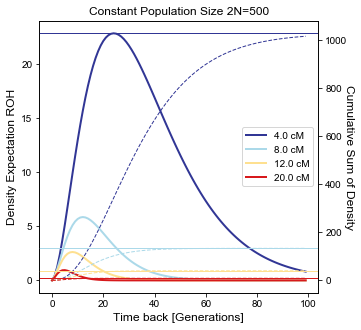

In [22]:
plot_time_exp(t_vec=np.arange(0,100), 
              bl_lengths=[0.04, 0.08, 0.12, 0.2], colors=["#313695", "#abd9e9", "#fee090", "#d7191c"])

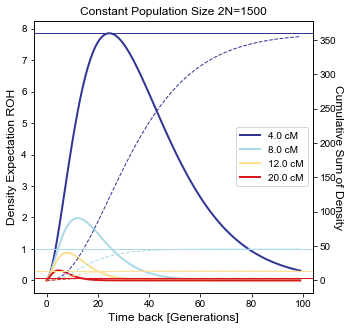

In [19]:
plot_time_exp(t_vec=np.arange(0,100), bl_lengths=[0.04, 0.08, 0.12, 0.2], 
              N=1500, colors=["#313695", "#abd9e9", "#fee090", "#d7191c"], 
              savepath="")

In [62]:
bl = 0.25
N = 100000
t_vec = np.arange(0,100000)

y = e_roh.roh_pdf_allchr_t_N(x=bl, t=t_vec, N=N)
y_cumsum = np.cumsum(y) ## For Cumulative Sum
y_cumfrac = y_cumsum/np.sum(y)
y_cumfrac[5]

0.5553749139986671

0.9853625676126379

# How much coalescence up until 10 generations ago

In [5]:
e_roh = Expected_Roh()

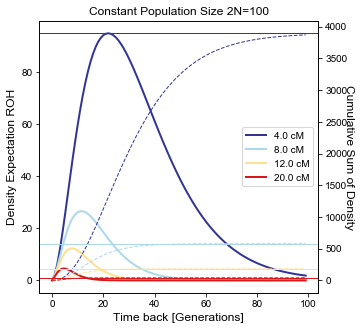

In [14]:
plot_time_exp(t_vec=np.arange(0,100), bl_lengths=[0.04, 0.08, 0.12, 0.2], 
              N=100, colors=["#313695", "#abd9e9", "#fee090", "#d7191c"], 
              savepath="")

# Test various summary statistics

In [16]:
###
vrange = [0.12, 2.5]
N_arr = [400, 800, 1600, 3200]  # The values of 2N
c_arr = [1, 2, 3] # The value of cousins

e_roh = Expected_Roh()  # Get the object to do calculation

x_arr = np.arange(vrange[0], vrange[1], 0.0001)
bw = x_arr[1] - x_arr[0]  # Bin Width
x_mean = (x_arr[1:] + x_arr[:-1]) / 2

y_roh_cs_nr = np.zeros((len(c_arr), len(x_mean)), dtype="float") # Container for N results
y_roh_cs = np.zeros((len(c_arr), len(x_mean)), dtype="float") # Container for N results
for i,c in enumerate(c_arr):
    y_roh_cs_nr[i,:] = e_roh.exp_roh_ind_rel(x_mean, m=(c*2+4), comm_anc=4) 
    y_roh_cs[i,:] = y_roh_cs_nr[i,:] * x_mean
    
y_roh_Ns_nr = np.zeros((len(N_arr), len(x_mean)), dtype="float") # Container for N results   
y_roh_Ns = np.zeros((len(N_arr), len(x_mean)), dtype="float") # Container for N results
for i,N in enumerate(N_arr):
    y_roh_Ns_nr[i,:] = e_roh.roh_pdf_allchr_N(x_mean, N=N) 
    y_roh_Ns[i,:] = y_roh_Ns_nr[i,:] * x_mean

### Print expectations for Blocks in certain ranges:

In [17]:
print(f"Blocks in Range: {vrange} Morgan")
print("Expected Sum ROH for Cousins 1/2/3:")
print(np.sum(y_roh_cs*bw, axis=1))

print("Expected Nr Blocks:")
print(np.sum(y_roh_cs_nr*bw, axis=1))

print("Avg. Block Length:")
print(np.sum(y_roh_cs*bw, axis=1) / np.sum(y_roh_cs_nr*bw, axis=1))

Blocks in Range: [0.12, 2.5] Morgan
Expected Sum ROH for Cousins 1/2/3:
[1.79196801 0.39969957 0.08786534]
Expected Nr Blocks:
[6.64435093 1.69886274 0.41117349]
Avg. Block Length:
[0.26969798 0.23527479 0.21369409]


In [156]:
print(f"Blocks in Range: {vrange} Morgan")
print(f"Expected Sum ROH for small Ne: {N_arr}")
print(np.sum(y_roh_Ns*bw, axis=1))

print("Expected Nr Blocks:")
print(np.sum(y_roh_Ns_nr*bw, axis=1))

print("Avg. Block Length:")
print(np.sum(y_roh_Ns, axis=1) / np.sum(y_roh_Ns_nr, axis=1))

Blocks in Range: [0.2, 0.4] Morgan
Expected Sum ROH for small Ne: [400, 800, 1600, 3200]
[0.21821256 0.10983044 0.05509754 0.02759452]
Expected Nr Blocks:
[0.81794126 0.4117915  0.20660614 0.10348132]
Avg. Block Length:
[0.26678267 0.26671371 0.26667911 0.26666179]


In [ ]:
215/205, 180/67, 158/49, 136/38

### Do expectations for Blocks in Windows. Per time interval

In [158]:
### This is copy from above
bl_lengths = [0.04, 0.08, 0.12, 0.16, 0.2]
N=500

t_vec = np.arange(0, 250)
y = np.array([e_roh.roh_pdf_allchr_t_N(bl, t=t_vec, N=N) for bl in bl_lengths])
y_cumsum = np.cumsum(y, axis=1) ## For Cumulative Sum

### Full Integral:
int_res = [e_roh.roh_pdf_allchr_N(x=bl, N=N) for bl in bl_lengths]

In [176]:
cut_t = 3
y_cumsum[:,cut_t]

array([4.00810689, 3.22538522, 2.60296668, 2.10701866, 1.71098506])

In [170]:
y_cumsum[:,-1]
y_relcumsum = y_cumsum / y_cumsum[:,-1, None]

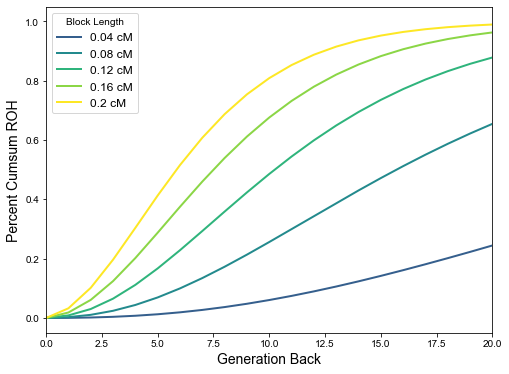

In [183]:
figsize=(8,6)
cmap = "viridis"
fs = 14
fs_l = 12
lw=2

cs = np.linspace(0.3,1,len(bl_lengths))
cmap = cm.get_cmap(cmap)

plt.figure(figsize=figsize)
ax = plt.gca()

for i in range(len(y_relcumsum)):
    ax.plot(t_vec, y_relcumsum[i,:], label=f"{bl_lengths[i]} cM", c=cmap(cs[i]), lw=lw)
ax.legend(loc="upper left", title="Block Length", fontsize=fs_l)

ax.set_ylabel("Percent Cumsum ROH", fontsize=fs)
ax.set_xlabel("Generation Back", fontsize=fs)
plt.xlim([0,20])
plt.show()

### Take Away:
Less than 20% of even long ROH (0.2 cM) from last 3 Generations

## Look at fractions of ROH in small population sizes

In [4]:
### Same function as in bar plot (Merge Eventually)
def create_cousins_roh(degrees=[1,2,3], bins = [[0.04,0.08],[0.08,0.12],[0.12,3.00]]):
    """Create ROH sharing in list of bins (list of [begin,end]) 
    for Cousins of degree degrees [list]
    return sharing [len(degrees), len(bins)]"""
    e_roh = Expected_Roh()
    c_roh = np.zeros((len(degrees),len(bins))) # Container for results Cousins
    for i,c in enumerate(degrees):
        for j,b in enumerate(bins):
            m = c*2 + 4
            c_roh[i,j] = e_roh.exp_roh_len_in_bin_rel(l=b, m=m, comm_anc=4, bins=10000)
    return c_roh

def create_Ne_roh(Ns= [400, 800, 1600, 3200, 6400], bins = [[0.04,0.08],[0.08,0.12],[0.12,3.00]]):
    """Create ROH sharing in list of bins (list of [begin,end]) 
    for Cousins of degree degrees [list]
    return sharing [len(degrees), len(bins)]"""
    e_roh = Expected_Roh()
    n_roh = np.zeros((len(Ns),len(bins))) # Container for results Cousins
    for i,N in enumerate(Ns):
        for j,b in enumerate(bins):
            n_roh[i,j] = e_roh.exp_roh_len_in_bin_N(b, N=N, bins=10000)
    return n_roh

In [5]:
%%time
bins = [[0.04,0.08],[0.08,0.12],[0.12,3.00]]
Ns=[200, 400, 800, 1600, 3200, 6400]
degrees=[1,2,3]

### Calcualte Expectations Cousins Lengths:
c_roh = create_cousins_roh(degrees=degrees, bins = bins)*100 # Multiplier for Morgan

### Calculate Expectations Ne Lengths:
n_roh = create_Ne_roh(Ns = Ns, bins = bins)*100 # Multiplier for Morgan

CPU times: user 372 ms, sys: 16.5 ms, total: 389 ms
Wall time: 393 ms


In [8]:
n_roh

array([[193.17396596,  68.3679241 , 132.2011448 ],
       [103.26154724,  35.49018848,  67.14883175],
       [ 53.42034066,  18.08446132,  33.84189459],
       [ 27.17378302,   9.12873591,  16.98850905],
       [ 13.7048964 ,   4.58620623,   8.51123245],
       [  6.88221693,   2.29858944,   4.25987171]])

In [9]:
frac_roh = n_roh[:,2] / n_roh[:,0]
frac_roh

array([0.68436315, 0.65027916, 0.63350204, 0.62518012, 0.62103588,
       0.61896795])

In [10]:
frac_roh = c_roh[:,2] / c_roh[:,0]
frac_roh

array([11.62325756,  6.89916543,  4.51171696])

In [6]:
### Run if Empirical Data is required for plot
df = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')

cm = [4,8,12]  # The Three Cut Offs
frac = 0.65    # The fraction of the short ROH substraction
min_stat = 0.8 # The Minimum Statistic

y_emp = df[f"sum_roh>{cm[2]}"]
x_emp = df[f"sum_roh>{cm[0]}"] - df[f"sum_roh>{cm[1]}"]

Saved to ./figures_test/statistic_cousin.png


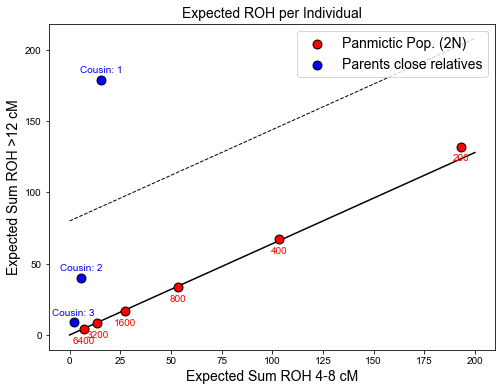

In [9]:
figsize=(8,6)
fs_l = 14
fs = 10
ratio= 0.64
offset=80
xmax = 200.0
empirical = False
savepath = "./figures_test/statistic_cousin.png"
ec = "k"

plt.figure(figsize=figsize)
ax=plt.gca()
ax.plot([0,xmax],[0,xmax*ratio], c="black", zorder=0)
ax.plot([0,xmax],np.array([0,xmax*ratio])+offset, "--", c="black", zorder=0, lw=1.0)

### Do small pop size
ax.scatter(n_roh[:,0], n_roh[:,2], s=80, c="r", zorder=1, label="Panmictic Pop. (2N)", ec=ec)
for i, txt in enumerate(Ns):
    ax.text(n_roh[i,0], n_roh[i,2]-10, f"{txt}", ha="center", fontsize=fs, c="r")

### Do first Cousins
ax.scatter(c_roh[:,0], c_roh[:,2], s=80, c="b", zorder=1, label="Parents close relatives", ec=ec)
for i, txt in enumerate(degrees):
    ax.text(c_roh[i,0], c_roh[i,2]+5, f"Cousin: {txt}", ha="center", fontsize=fs, c="b")

if empirical:
    ax.scatter(x_emp, y_emp, label="Empirical Individuals", s=20, alpha=0.5, c="silver", ec=ec)
    
ax.set_xlabel("Expected Sum ROH 4-8 cM", fontsize=fs_l)
ax.set_ylabel("Expected Sum ROH >12 cM", fontsize=fs_l)
ax.set_title("Expected ROH per Individual", fontsize=fs_l)
ax.legend(loc = "upper right", fontsize=fs_l)

if len(savepath)>0:
    plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
    print(f"Saved to {savepath}")

plt.show()

In [26]:
c_roh[:,2] - 0.65 * c_roh[:,0]

array([169.1758857 ,  36.20422839,   7.5206648 ])

# Test upward bias of ROH estimation
Idea: Test population size 500 and see what effect folding with "error" kernel has

### Get ROH Sum Densities

In [49]:
vrange = [0.02, 0.8]
N_arr = [200, 600, 1800, 5400]  # The values of 2N
det = 0.04 # Detection Threshold

e_roh = Expected_Roh()  # Get the object to do calculation

x_arr = np.arange(vrange[0], vrange[1], 0.0001)
bw = x_arr[1] - x_arr[0]  # Bin Width
x_mean = (x_arr[1:] + x_arr[:-1]) / 2
    
y_roh_Ns = np.zeros((len(N_arr), len(x_mean)), dtype="float") # Container for N results
for i,N in enumerate(N_arr):
    y_roh_Ns[i,:] = e_roh.roh_pdf_allchr_N(x_mean, N=N) * x_mean

In [25]:
np.sum(y_roh_Ns*bw, axis=1)*100

array([382.51826335, 135.62750003,  46.17823511,  15.50307517])

### Fold with Error Kernel

In [69]:
kernel= np.eye(len(x_mean)) ## Idendity Matrix

In [109]:
sigma = 0.004 # The width of the Gaussian
d = x_mean[None,:]-x_mean[:,None]
norm = 1/ (np.sqrt(2.*np.pi)*sigma)
kernel = norm * np.exp(-(d/sigma)**2 / 2) * bw

In [110]:
y_folded = np.dot(y_roh_Ns, kernel)
np.shape(y_folded)

(4, 7799)

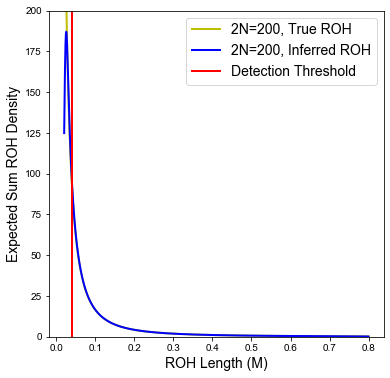

In [111]:
fs=14

fig = plt.figure(figsize=(6,6))
ax = plt.gca()
ax.plot(x_mean, y_roh_Ns[0,:], label=f"2N={N_arr[0]}, True ROH", lw=2, c="y")
ax.plot(x_mean, y_folded[0,:], label=f"2N={N_arr[0]}, Inferred ROH", lw=2, c="b")
ax.set_xlabel("ROH Length (M)", fontsize=fs)
ax.set_ylabel("Expected Sum ROH Density", fontsize=fs)
ax.axvline(x=0.04, label="Detection Threshold", lw=2, color="red")
ax.legend(loc="upper right", fontsize=fs)
ax.set_ylim(0,200)
plt.show()

In [112]:
i = np.searchsorted(x_mean, det) # Identify Cutoff
np.sum(y_roh_Ns[:,i:]*bw, axis=1)*100

array([382.51826335, 135.62750003,  46.17823511,  15.50307517])

In [113]:
np.sum(y_folded[:,i:]*bw, axis=1)*100

array([385.9310475 , 136.99743007,  46.66474038,  15.66873125])

# Area 51
Test various block thresholds

In [48]:
np.sqrt(6)

2.449489742783178

In [20]:
np.sum(y_roh_cs_nr*bw, axis=1)

array([6.64435093, 1.69886274, 0.41117349])

In [113]:
t = np.linspace(0,30,100)
y = (2*t)**2 * np.exp(-0.2*2*t)

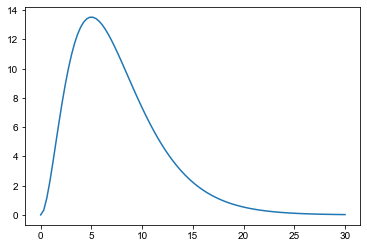

In [114]:
plt.plot(t, y)